# 🔍 Forensische Datenanalyse mit DuckLake

Dieses Notebook demonstriert eine **forensische Analyse von Webserver-Logs** mit Hilfe von **DuckLake/DuckDB**.  
Die Daten stammen aus einer Beispiel-CSV-Datei (`weblog.csv`) mit folgenden Spalten:  

- `IP` → Quell-IP-Adresse des Clients  
- `Time` → Zeitstempel des Requests  
- `URL` → aufgerufene Ressource  
- `Staus` → HTTP-Statuscode (Tippfehler in den Logs, entspricht `Status`)  

---

## Zweck und Ziele der Untersuchung

- Auffällige IP-Adressen identifizieren (mögliche Angreifer oder Bots)  
- Häufig aufgerufene Ressourcen (z. B. Login, Admin) untersuchen  
- Zeitliche Muster erkennen (z. B. Traffic-Spikes, Brute-Force)  
- HTTP-Statuscodes auswerten (z. B. viele Fehler → Attacken oder technische Probleme)  

Die Beweissicherung entfällt hier, da es sich um **Beispieldaten** handelt.  


## 1. Setup & Imports

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Verbindung (In-Memory)
con = duckdb.connect(database=':memory:')
print("✅ DuckLake bereit")


✅ DuckLake bereit


## 2. Daten laden

In [2]:
\
# CSV laden
df = pd.read_csv(r"C:\Users\DMQDCQR\Downloads\hallo\weblog.csv")

# Time-Spalte bereinigen und in datetime konvertieren
df["Time"] = pd.to_datetime(df["Time"].str.replace("[", "", regex=False),
                            format="%d/%b/%Y:%H:%M:%S",
                            errors="coerce")

# Tabelle registrieren
con.register("weblogs", df)

print("✅ Daten geladen, Anzahl Zeilen:", len(df))
df.head()


✅ Daten geladen, Anzahl Zeilen: 16007


,IP,Time,URL,Staus
0,10.128.2.1,2017-11-29 06:58:55,GET /login.php HTTP/1.1,200
1,10.128.2.1,2017-11-29 06:59:02,POST /process.php HTTP/1.1,302
2,10.128.2.1,2017-11-29 06:59:03,GET /home.php HTTP/1.1,200
3,10.131.2.1,2017-11-29 06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200
4,10.130.2.1,2017-11-29 06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200


## 3. Analyse auffälliger IP-Adressen

Top 10 IPs:
           IP   cnt
0  10.128.2.1  4257
1  10.131.0.1  4198
2  10.130.2.1  4056
3  10.129.2.1  1652
4  10.131.2.1  1626
5      chmod:    95
6         rm:    72
7        [Tue    17
8         sh:     7
9        [Thu     6


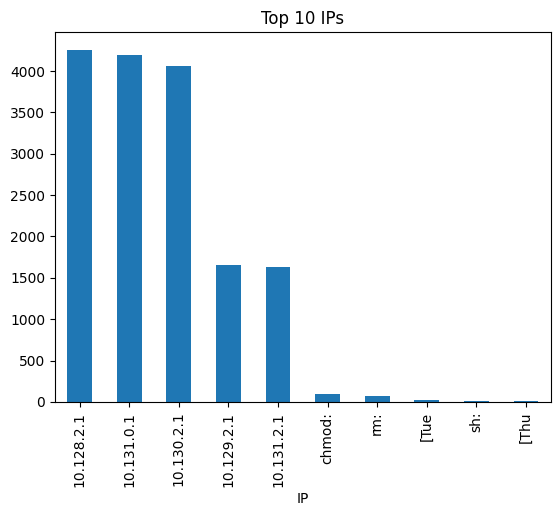

In [3]:
top_ips = con.execute("""
    SELECT IP, COUNT(*) AS cnt
    FROM weblogs
    GROUP BY IP
    ORDER BY cnt DESC
    LIMIT 10
""").fetchdf()

print("Top 10 IPs:")
print(top_ips)
top_ips.plot.bar(x="IP", y="cnt", legend=False, title="Top 10 IPs")
plt.show()


**Interpretation:**  
Eine ungewöhnlich hohe Anzahl an Requests von einer IP-Adresse kann auf **automatisierte Angriffe** (z. B. Brute-Force oder Bots) hindeuten.  


## 4. Häufig aufgerufene Ressourcen (URLs)

Top 10 URLs:
                                                 URL   cnt
0                            GET /login.php HTTP/1.1  3284
1                             GET /home.php HTTP/1.1  2640
2     GET /js/vendor/modernizr-2.8.3.min.js HTTP/1.1  1415
3                                     GET / HTTP/1.1   861
4  GET /contestproblem.php?name=RUET%20OJ%20Serve...   467
5                    GET /css/normalize.css HTTP/1.1   408
6                GET /css/bootstrap.min.css HTTP/1.1   404
7             GET /css/font-awesome.min.css HTTP/1.1   399
8                        GET /css/style.css HTTP/1.1   395
9                         GET /css/main.css HTTP/1.1   394


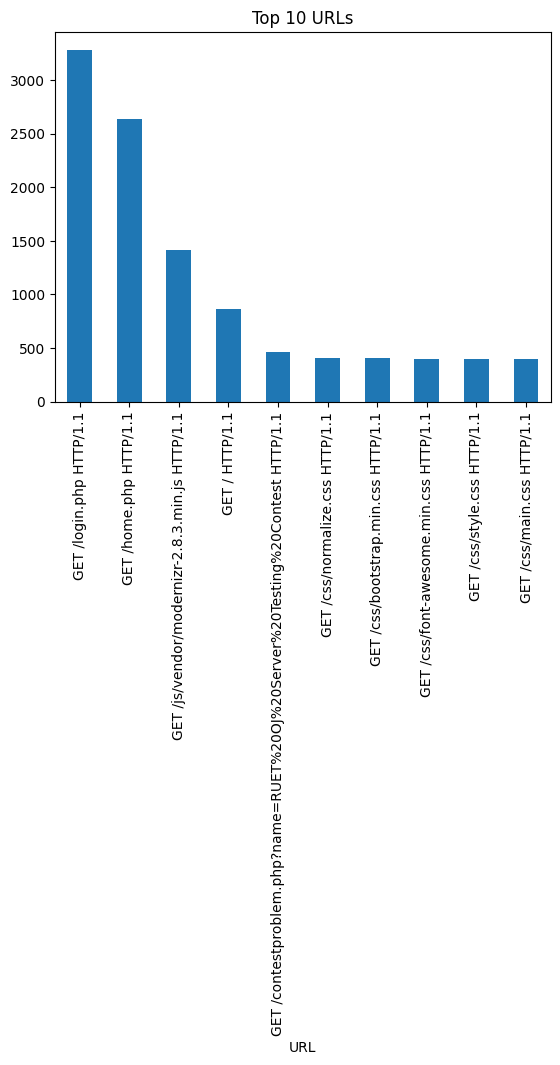

In [4]:
top_urls = con.execute("""
    SELECT URL, COUNT(*) AS cnt
    FROM weblogs
    GROUP BY URL
    ORDER BY cnt DESC
    LIMIT 10
""").fetchdf()

print("Top 10 URLs:")
print(top_urls)
top_urls.plot.bar(x="URL", y="cnt", legend=False, title="Top 10 URLs")
plt.show()


**Interpretation:**  
Wenn hier besonders oft **Login- oder Admin-Seiten** erscheinen, könnte dies auf **Brute-Force- oder Enumeration-Angriffe** hinweisen.  


## 5. Zeitliche Analyse (Requests pro Tag)

Requests pro Tag:
          day   cnt
0  2017-11-07     2
1  2017-11-08   106
2  2017-11-09   236
3  2017-11-10    64
4  2017-11-11   286
5  2017-11-12   338
6  2017-11-13   230
7  2017-11-14   150
8  2017-11-15    78
9  2017-11-16   384
10 2017-11-17   481
11 2017-11-18    96
12 2017-11-19   164
13 2017-11-20    58
14 2017-11-21    47
15 2017-11-22    60
16 2017-11-23   380
17 2017-11-24    94
18 2017-11-25   250
19 2017-11-26   179
20 2017-11-29   580
21 2017-11-30  2991
22 2017-12-01   468
23 2017-12-02   168
24 2017-12-03   105
25 2017-12-12    86
26 2017-12-13   133
27 2017-12-14   165
28 2017-12-15   100
29 2017-12-16   155
30 2017-12-17    92
31 2017-12-18   178
32 2017-12-19    55
33 2017-12-20    98
34 2017-12-21    72
35 2017-12-22    11
36 2017-12-23    43
37 2018-01-16    76
38 2018-01-17    29
39 2018-01-18    63
40 2018-01-29  5092
41 2018-02-15    20
42 2018-02-16    33
43 2018-02-17    65
44 2018-02-18    34
45 2018-02-19    32
46 2018-02-20    62
47 2018-02-21   110
48

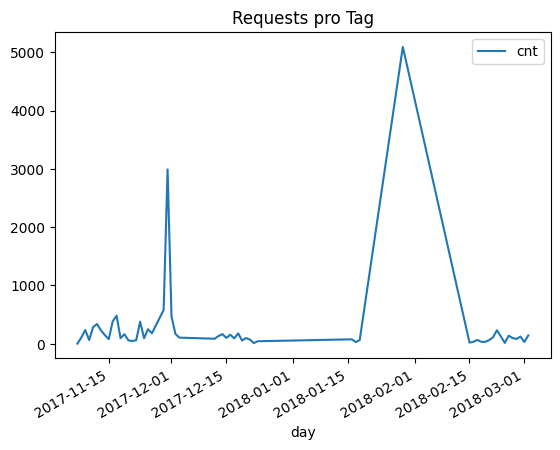

In [5]:
requests_per_day = con.execute("""
    SELECT CAST(Time AS DATE) AS day, COUNT(*) AS cnt
    FROM weblogs
    GROUP BY day
    ORDER BY day
""").fetchdf()

print("Requests pro Tag:")
print(requests_per_day)
requests_per_day.plot(x="day", y="cnt", kind="line", title="Requests pro Tag")
plt.show()


**Interpretation:**  
Spitzen in der zeitlichen Verteilung können auf **koordinierte Angriffe oder Lasttests** hindeuten.  


## 6. Analyse der HTTP-Statuscodes

HTTP-Statuscodes:
           Staus    cnt
0            200  11330
1            302   3498
2            304    658
3            404    251
4             No    167
5            206     52
6          2018]     28
7          2017]      7
8         dumped      5
9      Assertion      4
10       Aborted      4
11         found      2
12  Segmentation      1


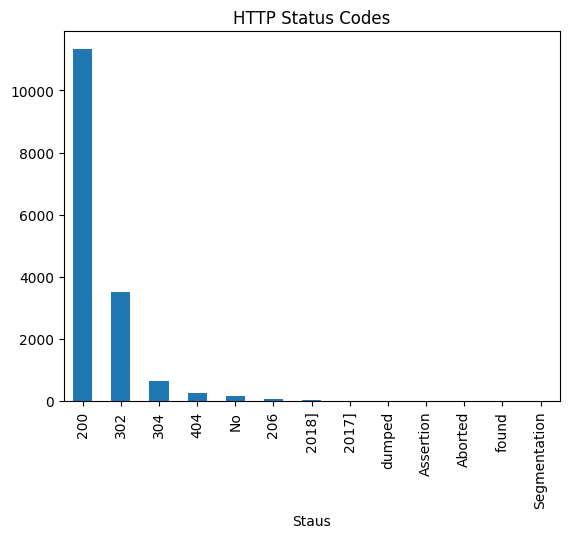

In [6]:
status_codes = con.execute("""
    SELECT Staus, COUNT(*) AS cnt
    FROM weblogs
    GROUP BY Staus
    ORDER BY cnt DESC
""").fetchdf()

print("HTTP-Statuscodes:")
print(status_codes)
status_codes.plot.bar(x="Staus", y="cnt", legend=False, title="HTTP Status Codes")
plt.show()


**Interpretation:**  
- Viele **404 (Not Found)** können auf **Directory Scans** (Angriffe zur Pfaderkennung) hinweisen.  
- Viele **500er Fehler** können auf **Serverprobleme oder Exploit-Versuche** hindeuten.  


## 7. Fazit

In dieser forensischen Analyse wurden folgende Punkte untersucht:  

- **Top-IPs**: Identifikation auffälliger Hosts mit vielen Requests.  
- **Top-URLs**: Analyse, welche Ressourcen im Fokus standen.  
- **Zeitliche Verteilung**: Erkennung von Anomalien oder Spitzenlasten.  
- **Statuscodes**: Hinweise auf Fehler, Angriffsversuche oder fehlerhafte Konfigurationen.  

👉 Diese Methode kann genutzt werden, um **Anomalien im Webverkehr frühzeitig zu erkennen** und Auffälligkeiten zu dokumentieren.  


Forensische Auffälligkeiten

Ungewöhnliche Statuscodes

Neben regulären Codes (200, 302, 404) treten Einträge wie "No", "2018]", "dumped", "Segmentation" auf → Hinweis auf inkonsistente Logs oder Angriffsversuche (Log-Injection, Manipulation).

Anomalien im Zeitverlauf

Zwei massive Peaks im Dezember 2017 und Februar 2018 → mögliches Zeichen für DoS-Attacken, Brute-Force-Login-Versuche oder Lasttests.

Starker Einbruch unmittelbar nach den Peaks → könnte auf Blockierung durch Schutzmechanismen oder Abbruch der Attacke hinweisen.

Auffällige URLs

Viele Zugriffe auf /login.php → Indikator für gezielte Login-Versuche (mögliche Brute-Force).

Ungewöhnliche URL wie "200%20Server%20Testing%20Contest" → deutet auf Encoding-Manipulation oder Injection-Test hin.

Verdächtige IP-Einträge

Neben normalen internen IPs (10.128.2.1, 10.131.0.1 etc.) finden sich Zeichenketten wie "chmod:", "rm:", "sh:" → klare Hinweise auf versuchte Kommando-Injektionen (Shell-Befehle in Logeinträgen).

Diese Muster sind typisch für Exploits, die Befehle über Webserver-Schwachstellen einschleusen wollen.